In [2]:
# Import all the libraries !!
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
import torch.nn.functional as F
from torchvision import models

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix ,roc_curve
import seaborn as sns

In [3]:
!pip install torch_geometric
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:0000:01


In [4]:
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Dataset, Data, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from torch_geometric.utils import to_networkx



from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F
from torch.utils.data import random_split


In [5]:
chunk_size = 25

# List of Parquet file paths
file_paths = [
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Create a Parquet file reader object
    parquet_file = pq.ParquetFile(file_path)
    
    # Determine the total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Calculate the number of chunks
    num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size else 0)
    
    # Loop over the file in chunks
    for chunk_index in range(num_chunks):
        # Read a chunk of rows from the file
        chunk = parquet_file.read_row_group(chunk_index, columns=None)
        df = chunk.to_pandas()
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)


In [6]:
def to_3d(arr):
    vishak=[]
    for i in range (0,3):
        vis=np.stack(np.stack(arr)[i],axis=-1)
        vishak.append(vis)
    vishak=np.array(vishak)
    return vishak

In [7]:
data["X_jets"]  = data["X_jets"].apply(to_3d)

In [8]:
def image_to_graph(image, patch_size=5, n_neighbors=5):
        """
        Convert an image to a graph of its 5x5 patches.

        Parameters:
        - image: A (125, 125, 3) numpy array.
        - patch_size: Size of the square patches (default 5).
        - n_neighbors: Number of neighbors for KNN (default 5).

        Returns:
        - nodes: An array of node features.
        - edges: A list of tuples (i, j, mse) representing edges and their MSE.
        """
        # Validate image shape
        
        assert image.shape[0] == image.shape[1], "Image must be square."

        # Number of patches along one dimension
        num_patches = image.shape[0] // patch_size

        # Initialize nodes and edges
        nodes = []
        edges = []

        # Create patches and flatten them to create node features
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size, :].reshape(-1)
                nodes.append(patch)

        nodes = np.array(nodes)

        # Use KNN to find nearest neighbors for each node
        nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(nodes)
        distances, indices = nbrs.kneighbors(nodes)

        # Calculate MSE for each pair of neighbors and create edges
        for i in range(indices.shape[0]):
            for j in range(1, indices.shape[1]):  # Start from 1 to skip self-connection
                mse = mean_squared_error(nodes[i], nodes[indices[i, j]])
                edges.append((i, indices[i, j], mse))

        return nodes, edges

In [9]:
class QuarkGluonDataset(Dataset):
    
    def __init__(self, dataframe, root='', transform=None, pre_transform=None):
        """
        Custom dataset for quarks and gluons classification.
        
        Parameters:
        - image_list: A list of (125, 125, 3) numpy arrays.
        - labels: A list of integers (0 or 1) representing the class labels for the images.
        """
        self.dataframe = dataframe
        super(QuarkGluonDataset, self).__init__(root, transform, pre_transform)
    
   
    def len(self):
        return len(self.dataframe)
    
    def get(self, idx):
        # Convert an image to graph data
        image = self.dataframe.iloc[idx]['X_jets']
        image = image.transpose(1,2,0)
        label = self.dataframe.iloc[idx]['y']
#         print(type(image))
        nodes, edges = image_to_graph(image)
        
        # Convert to PyTorch tensors
        x = torch.tensor(nodes, dtype=torch.float)  # Node features
        edge_index = torch.tensor([(i, j) for i, j, _ in edges], dtype=torch.long).t().contiguous()  # Edge indices
        edge_attr = torch.tensor([mse for _, _, mse in edges], dtype=torch.float).unsqueeze(1)  # Edge attributes
        y = torch.tensor([label], dtype=torch.long)  # Label
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    

In [10]:
dataset = QuarkGluonDataset(data)

In [12]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Perform the random split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
from torch.nn import BatchNorm1d , Dropout,  Linear

class DeepGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(DeepGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 1024)
        self.bn1 = BatchNorm1d(1024)
        self.conv2 = GCNConv(1024, 512)
        self.bn2 = BatchNorm1d(512)
        self.conv3 = GCNConv(512, 256)
        self.bn3 = BatchNorm1d(256)
        self.conv4 = GCNConv(256, 128)
        self.bn4 = BatchNorm1d(128)
        self.dropout = Dropout(0.5)
        self.lin = Linear(128, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.conv4(x, edge_index)))

        x = global_mean_pool(x, batch)  # Pooling to use graph-level features
        x = self.dropout(x)
        x = self.lin(x)

        return x

# Inference

In [14]:
num_node_features = 75  # Number of features per node
num_classes = 2  # Number of classes for binary classification

model = DeepGNN(num_node_features=num_node_features, num_classes=num_classes)
model.load_state_dict(torch.load("/kaggle/input/gcnconv-final/best_model.pth"))
print(model)

DeepGNN(
  (conv1): GCNConv(75, 1024)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(1024, 512)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(512, 256)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GCNConv(256, 128)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

model.eval()  # Set the model to evaluation mode
y_true = []
y_scores = []

with torch.no_grad(), tqdm(valid_loader, desc="Evaluating", leave=False) as tepoch:
    for data in tepoch:
        data = data.to(device)
        outputs = model(data)
        # Apply sigmoid if your model outputs logits
        probs = torch.sigmoid(outputs).squeeze()
        
        # Assuming the positive class is the second column
        positive_class_probs = probs[:, 1] if probs.ndim == 2 else probs
        labels = data.y
        # Store true labels and positive class predictions
        y_true.extend(labels.tolist())
        y_scores.extend(positive_class_probs.tolist())

# Now both y_true and y_scores are 1-dimensional
roc_auc = roc_auc_score(y_true, y_scores)
print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: 0.7697586872586872


ROC AUC Score: 0.7697586872586872


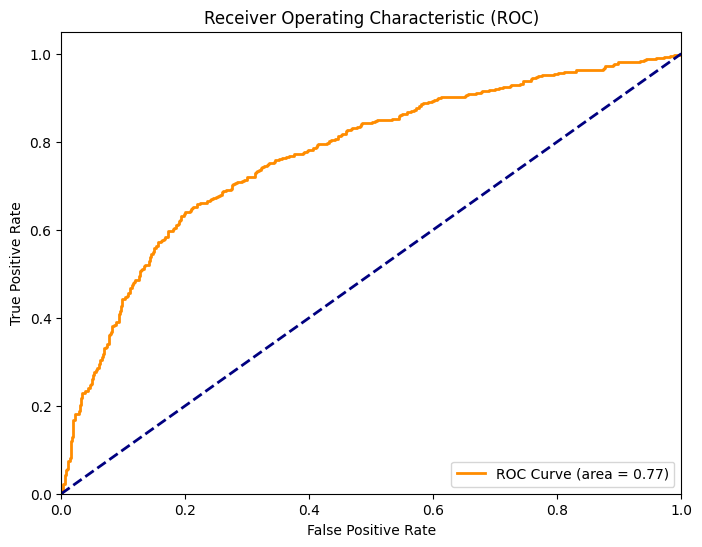

In [19]:
roc_auc = roc_auc_score(y_true, y_scores)
print(f'ROC AUC Score: {roc_auc}')

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()